In [1]:
import pandas as pd
import numpy as np
import os, time, stat, io, glob, pickle
from scipy.stats import gamma, norm
from sklearn.linear_model import LinearRegression
from IPython.core.display import display, HTML

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('fivethirtyeight')
import plotly.io as pio

%load_ext autoreload
%autoreload 2
from covid_data_helper import *
from coronita_chart_helper import *
from coronita_model_helper import *
from coronita_web_helper import *
from coronita_bokeh_helper import *

from matplotlib.backends.backend_pdf import PdfPages


In [2]:
## DATA INGESTION ##

df_st_testing = get_covid19_tracking_data()

df_census = get_census_pop()

counties_geo = get_counties_geo()

# df_jhu_counties = get_jhu_counties()

df_st_testing_fmt = df_st_testing.copy()
df_st_testing_fmt = df_st_testing_fmt.rename(columns={'death':'deaths','positive':'cases'}).unstack('code')

try:
    df_interventions = get_state_policy_events()
except:
    df_interventions = pd.DataFrame()

df_goog_mob_us = get_goog_mvmt_us()
df_goog_mob_state = get_goog_mvmt_state(df_goog_mob_us)

df_counties = get_complete_county_data(df_census, df_goog_mob_us)

df_hhs_hosp = get_hhs_hosp()

df_can = get_can_data()

df_vax_hes = get_vax_hesitancy_data()



State Testing Data Last Observation:  20210307
Got COVID19 Tracking Data
Got CDC Death Data
Got HHS testing data
Got HHS hospital data.
Got Census Data
Got counties geo json
Got KFF Policy dates
Got Google Movement Data
Got NYS DOH data
Got NYT county level data.
Got NYC DOH data
Got Complete County Time Series Data
Got HHS hospitalization data.
Got COVID Act Now data.
Got Census Data
Got HHS Vaccine Hesitancy Data.


In [93]:
try:
    list_of_files = glob.glob('./output/df_fore_allstates_*.pkl') # * means all if need specific format then *.csv
    latest_file = max(list_of_files, key=os.path.getctime)
    print('last forecast: ', latest_file)
    df_prevfore_allstates = pd.read_pickle(latest_file)
except:
    if 'df_fore_allstates' in globals().keys():
        if df_fore_allstates.shape[0] > 0:
            df_prevfore_allstates = df_fore_allstates.copy()
            
            
list_of_files = glob.glob('./output/allstate_model_dicts_*.pkl') # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
print(latest_file)
with open(latest_file, 'rb') as handle:
    allstate_model_dicts = pickle.load(handle)


last forecast:  ./output/df_fore_allstates_20210719.pkl
./output/allstate_model_dicts_20210719.pkl


In [94]:
state_code = 'US'
model_dict = allstate_model_dicts[state_code]

In [99]:
model_dict['df_rts'].reindex(model_dict['df_agg'].index)

,cases_daily,test_share,deaths_daily,weighted_average,rt_scenario,rt_preimmune
dt,,,,,,
2020-01-28,NaN,NaN,2.090239,NaN,NaN,NaN
2020-01-29,NaN,NaN,2.115435,NaN,4.501036,4.489626
2020-01-30,NaN,NaN,2.116819,NaN,2.320770,2.314887
2020-01-31,NaN,NaN,2.073125,NaN,2.368770,2.362767
2020-02-01,NaN,NaN,2.015389,NaN,2.379717,2.373688
...,...,...,...,...,...,...
2021-11-20,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-21,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-22,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
# model_dict['df_rts']
model_dict['df_agg']['exposed_daily'].div(
    model_dict['df_agg']['infectious'].shift(1)).mul((model_dict['covid_params']['d_infect']))

dt
2020-01-28         NaN
2020-01-29    4.501036
2020-01-30    2.320770
2020-01-31    2.368770
2020-02-01    2.379717
                ...   
2021-11-20    0.732327
2021-11-21    0.733460
2021-11-22    0.734631
2021-11-23    0.735832
2021-11-24    0.737059
Length: 667, dtype: float64

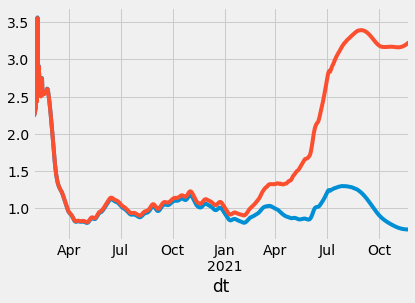

In [44]:
rt_scenario = model_dict['df_agg']['exposed_daily'].div(
    model_dict['df_agg']['infectious'].shift(1)).mul((model_dict['covid_params']['d_infect']))

rt_scenario.plot()
# allstate_model_dicts['NY']['df_rts']['rt_scenario'].plot()

rt_preimmune = rt_scenario.div(
    model_dict['df_agg']['susceptible'] / model_dict['tot_pop'])

rt_preimmune.plot()
# allstate_model_dicts['NY']['df_rts']['rt_preimmune'].plot()


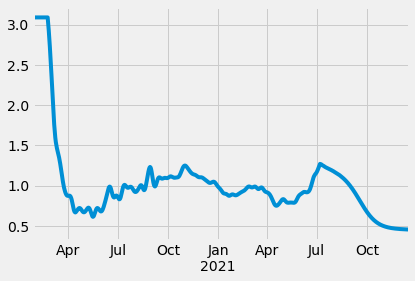

In [46]:
allstate_model_dicts['NY']['df_rts']['rt_nochange'].plot()

In [29]:
allstate_model_dicts['US']['df_rts']

,cases_daily,test_share,deaths_daily,weighted_average
dt,,,,
2020-01-28,NaN,NaN,2.090239,NaN
2020-01-29,NaN,NaN,2.115435,NaN
2020-01-30,NaN,NaN,2.116819,NaN
2020-01-31,NaN,NaN,2.073125,NaN
2020-02-01,NaN,NaN,2.015389,NaN
...,...,...,...,...
2021-07-02,1.346333,1.370440,NaN,1.361843
2021-07-03,1.385864,1.373869,NaN,1.365593
2021-07-04,1.401073,1.372766,NaN,1.367139


In [ ]:
df_tab_us['Hyp. Pre-Immunity Rt'] = model_dict['df_rts']['weighted_average'].dropna().iloc[-1] / (
            model_dict['df_agg'].loc[pd.Timestamp.today().normalize(), 'susceptible'] / model_dict['tot_pop'])

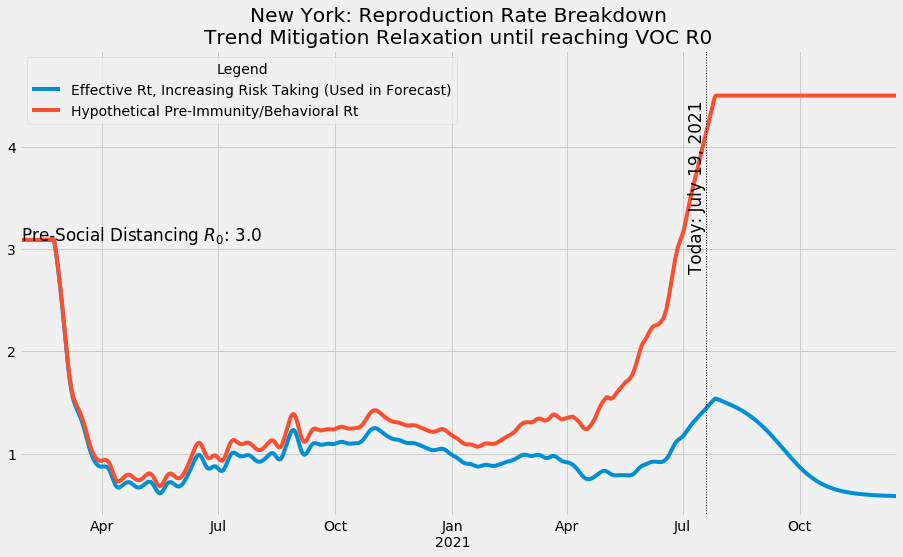

In [26]:
ch_rt_scen_explanation(model_dict)

In [8]:
raw_can = get_can_data()

Got COVID Act Now data.


In [10]:
raw_can.columns

Index(['date', 'country', 'county', 'fips', 'lat', 'long', 'locationId',
       'actuals.cases', 'actuals.deaths', 'actuals.positiveTests',
       'actuals.negativeTests', 'actuals.contactTracers',
       'actuals.hospitalBeds.capacity',
       'actuals.hospitalBeds.currentUsageTotal',
       'actuals.hospitalBeds.currentUsageCovid',
       'actuals.hospitalBeds.typicalUsageRate', 'actuals.icuBeds.capacity',
       'actuals.icuBeds.currentUsageTotal',
       'actuals.icuBeds.currentUsageCovid', 'actuals.icuBeds.typicalUsageRate',
       'actuals.newCases', 'actuals.vaccinesDistributed',
       'actuals.vaccinationsInitiated', 'actuals.vaccinationsCompleted',
       'metrics.testPositivityRatio', 'metrics.testPositivityRatioDetails',
       'metrics.caseDensity', 'metrics.contactTracerCapacityRatio',
       'metrics.infectionRate', 'metrics.infectionRateCI90',
       'metrics.icuHeadroomRatio', 'metrics.icuHeadroomDetails',
       'metrics.icuCapacityRatio', 'riskLevels.overall',
      

In [11]:
from my_can_apikey import can_apikey
df_can_raw = pd.read_json(f'https://api.covidactnow.org/v2/states.timeseries.json?apiKey={can_apikey}')
df_can = df_can_raw.copy()

df_can['dt'] = pd.to_datetime(df_can['date'])
df_can = df_can.set_index(['state', 'dt'])
print('Got COVID Act Now data.')

KeyError: 'date'

In [88]:
import requests

# url = f'https://api.covidactnow.org/v2/states.timeseries.json?apiKey={can_apikey}'
url = f'https://api.covidactnow.org/v2/country/US.json?apiKey={can_apikey}'

response = requests.get(url)
csv_response = (response.text)

In [89]:
import json


In [90]:
can_json = json.loads(csv_response)

In [91]:
df_can_full = pd.json_normalize(can_json)
df_can_full.head()

,fips,country,state,county,level,lat,locationId,long,population,lastUpdatedDate,...,annotations.caseDensity.anomalies,annotations.contactTracerCapacityRatio,annotations.infectionRate.sources,annotations.infectionRate.anomalies,annotations.infectionRateCI90.sources,annotations.infectionRateCI90.anomalies,annotations.icuHeadroomRatio,annotations.icuCapacityRatio,annotations.vaccinationsInitiatedRatio,annotations.vaccinationsCompletedRatio
0,0,US,None,None,country,None,iso1:us,None,331486822,2021-07-19,...,[],None,"[{'type': 'NYTimes', 'url': 'https://github.co...",[],"[{'type': 'NYTimes', 'url': 'https://github.co...",[],None,None,None,None


In [92]:
df_can_full.columns.to_list()

['fips',
 'country',
 'state',
 'county',
 'level',
 'lat',
 'locationId',
 'long',
 'population',
 'lastUpdatedDate',
 'url',
 'metrics.testPositivityRatio',
 'metrics.testPositivityRatioDetails.source',
 'metrics.caseDensity',
 'metrics.contactTracerCapacityRatio',
 'metrics.infectionRate',
 'metrics.infectionRateCI90',
 'metrics.icuHeadroomRatio',
 'metrics.icuHeadroomDetails.currentIcuCovid',
 'metrics.icuHeadroomDetails.currentIcuCovidMethod',
 'metrics.icuHeadroomDetails.currentIcuNonCovid',
 'metrics.icuHeadroomDetails.currentIcuNonCovidMethod',
 'metrics.icuCapacityRatio',
 'metrics.vaccinationsInitiatedRatio',
 'metrics.vaccinationsCompletedRatio',
 'riskLevels.overall',
 'riskLevels.testPositivityRatio',
 'riskLevels.caseDensity',
 'riskLevels.contactTracerCapacityRatio',
 'riskLevels.infectionRate',
 'riskLevels.icuHeadroomRatio',
 'riskLevels.icuCapacityRatio',
 'actuals.cases',
 'actuals.deaths',
 'actuals.positiveTests',
 'actuals.negativeTests',
 'actuals.contactTracers'

In [87]:
df_can_full[['state','actuals.vaccinesAdministeredDemographics.age.0-19']].dropna()

,state,actuals.vaccinesAdministeredDemographics.age.0-19
30,NE,525411.0


In [66]:
df_can_full.columns.to_list()


['fips',
 'country',
 'state',
 'county',
 'level',
 'lat',
 'locationId',
 'long',
 'population',
 'lastUpdatedDate',
 'url',
 'metricsTimeseries',
 'actualsTimeseries',
 'riskLevelsTimeseries',
 'metrics.testPositivityRatio',
 'metrics.testPositivityRatioDetails.source',
 'metrics.caseDensity',
 'metrics.contactTracerCapacityRatio',
 'metrics.infectionRate',
 'metrics.infectionRateCI90',
 'metrics.icuHeadroomRatio',
 'metrics.icuHeadroomDetails.currentIcuCovid',
 'metrics.icuHeadroomDetails.currentIcuCovidMethod',
 'metrics.icuHeadroomDetails.currentIcuNonCovid',
 'metrics.icuHeadroomDetails.currentIcuNonCovidMethod',
 'metrics.icuCapacityRatio',
 'metrics.vaccinationsInitiatedRatio',
 'metrics.vaccinationsCompletedRatio',
 'riskLevels.overall',
 'riskLevels.testPositivityRatio',
 'riskLevels.caseDensity',
 'riskLevels.contactTracerCapacityRatio',
 'riskLevels.infectionRate',
 'riskLevels.icuHeadroomRatio',
 'riskLevels.icuCapacityRatio',
 'actuals.cases',
 'actuals.deaths',
 'actual